<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/cnn_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# <font color='Blue'>Image classification, object detection, and image segmentation</font>        <img src="https://upload.wikimedia.org/wikipedia/commons/9/9a/Computervision_logo.svg" width=500 height=150>

>>>>***With one picture***





#<font color='Green'><b>The details of this Notebook are explained in this YouTube video</b></font>
<center>

  <a href="https://www.youtube.com/watch?v=Eh9WnEKnh6U&t=0s" target="_blank">

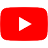

  </a>
</center>















<br>

<br><br>

---
#<font color='SeaGreen'>Chapter 1. Image classification</font>

>>>>***With 2 models***


In [14]:
#@title Imports

import tensorflow as tf
import tensorflow_hub as hub

import requests
from io import BytesIO

import numpy as np

from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps  # For drawing onto the image.

import matplotlib.pyplot as plt

from IPython.display import HTML

In [2]:
#@title Helper functions for loading image (hidden)


def preprocess_image(image):
  image = np.array(image)
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])  # reshape into shape [batch_size, height, width, num_channels]
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(img_url, headers={'User-agent': 'C'})
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  img = load_image_from_url(image_url)

  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)

  img = tf.image.resize_with_pad(img, image_size, image_size)

  return img, img_raw



def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 7) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()


def run_model_on_image(p_image, p_classifier,p_classes):
  probabilities = tf.nn.softmax(p_classifier(p_image)).numpy()

  top_n = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:4].numpy()
  #np_classes = np.array(classes)

  line = ''
  for i, class_index in enumerate(top_n):
    line = line +  f'{i+1:2}) {class_index:5} - {p_classes[class_index]};   p = {probabilities[0][top_n][i]:.4f}' + '\n'

  return line

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img


In [15]:
#@title Load 2 models and class labels for them


input_size = 299
classifier =  hub.load("https://www.kaggle.com/models/google/inception-v3/TensorFlow2/classification/2")

input_size = 224
classifier2 = hub.load("https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/classification/1")



# class labels
labels_path = tf.keras.utils.get_file('imagenet1k_wordnet_lemmas.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
classes = np.array(open(labels_path).read().splitlines())
labels_path2 = tf.keras.utils.get_file('imagenet1k_wordnet_lemmas.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
#classes2 = np.array(open(labels_path2).read().splitlines())
classes2 = np.array(open(labels_path2).read().splitlines())[1:]




<br><br>
---
## Two Models and one photo

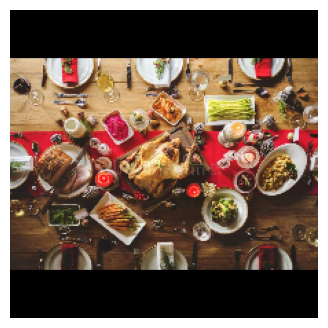

In [20]:
#@title Select an Input Image { run: "auto" }

image_name = "dinner" # @param ['Vilnius', 'Vilnius 2', 'Vilnius 3', 'Paris','tiger','Kaunas_Castle','funicular','Klaipėda','Klaipėda 2','Klaipėda 3','stem cell','climbing','skiing','Japanese kitchen 1832','clock tower', 'broccoli', 'pans', 'dinner']

images_for_test_map = {
    "Vilnius": "https://upload.wikimedia.org/wikipedia/commons/a/a4/Baltas_by_Augustas_Didzgalvis.jpg",
    "Vilnius 2": "https://upload.wikimedia.org/wikipedia/commons/9/9a/%27Church_of_St.Anne_and_St._Bernardine%27_Vilnius.jpg",
    "Vilnius 3": "https://upload.wikimedia.org/wikipedia/commons/0/02/Vilniaus_televizijos_bokštas%2C_2023.jpg",
    "Paris": "https://upload.wikimedia.org/wikipedia/commons/4/4b/La_Tour_Eiffel_vue_de_la_Tour_Saint-Jacques%2C_Paris_août_2014_%282%29.jpg",
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    "Kaunas_Castle": "https://upload.wikimedia.org/wikipedia/commons/6/61/Kaunas_Castle_-_panorama.JPG",
    "funicular": "https://upload.wikimedia.org/wikipedia/commons/9/95/Žaliakalnis_funicular.jpg",
    "Klaipėda": "https://upload.wikimedia.org/wikipedia/commons/0/03/Quite_summer_evening_in_the_port_city_Klaipeda.jpg",
    "Klaipėda 2": "https://upload.wikimedia.org/wikipedia/commons/7/75/Klaipėda_Castle1.jpg",
    "Klaipėda 3": "https://upload.wikimedia.org/wikipedia/commons/b/b1/Klaipėdos_jūros_vartai.Iš_aukščiau.jpg",
    "stem cell":"https://upload.wikimedia.org/wikipedia/commons/6/6c/HeLa_cells_stained_with_Hoechst_33258.jpg",
    "climbing": "https://upload.wikimedia.org/wikipedia/commons/1/19/Crack_climbing_in_Indian_Creek%2C_Utah.jpg",
    "skiing":"https://upload.wikimedia.org/wikipedia/commons/8/84/Ski_Famille_-_Family_Ski_Holidays.jpg",
    "Japanese kitchen 1832":"https://upload.wikimedia.org/wikipedia/commons/6/69/Nagasaka-Dejima-1832.jpg",
    "clock tower":"https://upload.wikimedia.org/wikipedia/commons/5/58/Clock_of_Erbil.jpg",
    "broccoli" : "https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Broccoli_and_cross_section_edit.jpg/220px-Broccoli_and_cross_section_edit.jpg",
    "pans" : "https://cdn.thewirecutter.com/wp-content/media/2024/04/carbonsteelpans-2048px-08667-2x1-1.jpg?width=2048&quality=75&crop=2:1&auto=webp",
    "dinner" : "https://thumbs.dreamstime.com/b/christmas-family-dinner-table-concept-80369269.jpg",
}


img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, input_size)
show_image(image, '')

model_answer = run_model_on_image(image, classifier,classes)

model_answer2 = run_model_on_image(image, classifier2,classes2)

HTML("<h1 style='font-size: 26px; color: orange;'>Answer from Model 1 <br><br><i>" + str(model_answer).replace('\n', '<br>') + "</i></h1> <br>" + "<h1 style='font-size: 26px; color: green;'>Answer from Model 2 <br><br><i> " + str(model_answer2).replace('\n', '<br>') + "</i></h1>")


<br><br>
---

## Let's cut a piece out of the photo and try again

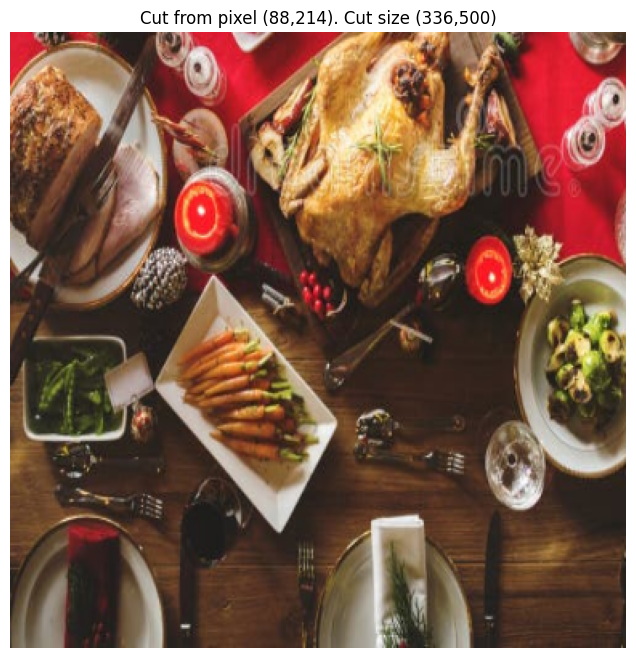

In [5]:
#@title Enter the upper right corner cropping point (in %)  { run: "auto" }


x = 11 # @param {type:"slider", min:0, max:100, step:1}
y = 39 # @param {type:"slider", min:0, max:100, step:1}

### @markdown ---
###input_size_zoom = input_size

cut_size_in_pixels = 500 # @param {type:"integer"}

x_cord = int(original_image.shape[2]*x/100)
y_cord = int(original_image.shape[1]*y/100)

image_cut = original_image[:,y_cord:y_cord+cut_size_in_pixels,x_cord:x_cord+cut_size_in_pixels,:]

image = tf.image.resize(image_cut, [input_size, input_size])

show_image(image, f'Cut from pixel ({x_cord},{y_cord}). Cut size ({image_cut.shape[1]},{image_cut.shape[2]})')

model_answer = run_model_on_image(image, classifier,classes)
model_answer2 = run_model_on_image(image, classifier2,classes2)

HTML("<h1 style='font-size: 26px; color: blue;'>Answer from Model 1 <br><br><i>" + str(model_answer).replace('\n', '<br>') + "</i></h1> <br>" + "<h1 style='font-size: 26px; color: green;'>Answer from Model 2 <br><br><i> " + str(model_answer2).replace('\n', '<br>') + "</i></h1>")



<br><br>

---
#<font color='SeaGreen'>Chapter 2. Object Detection</font>


In [24]:
#@title Load model and class labels for them

detector = hub.load("https://www.kaggle.com/models/google/faster-rcnn-inception-resnet-v2/TensorFlow1/faster-rcnn-openimages-v4-inception-resnet-v2/1").signatures['default']
labels_path_detector = tf.keras.utils.get_file('detector_600_labels.txt','https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv')
classes_detector = np.array(open(labels_path_detector).read().splitlines())


In [7]:
#@title Helper functions (hidden)

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


def run_detector_2(detector, p_img):
  img = tf.cast(p_img[0] * 255, tf.uint8)
  converted_img  = p_img
  result = detector(converted_img)

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=20)

  display_image(image_with_boxes)

  return result

>## Detector

In [ ]:
detector_output = run_detector_2(detector, original_image) # original_image

Found 100 objects.


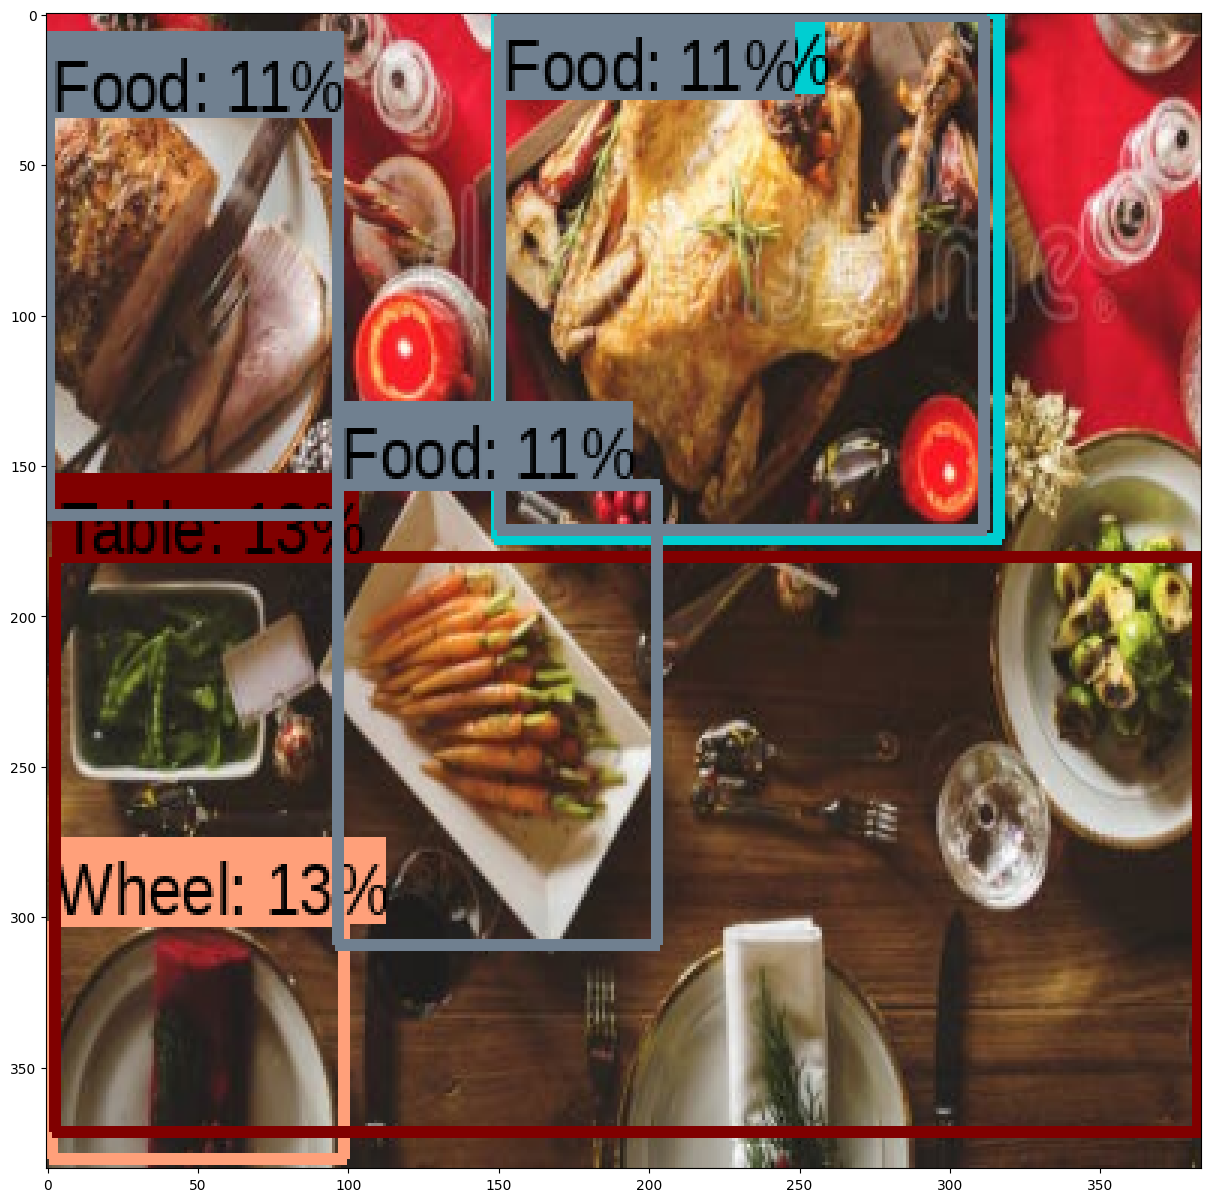

In [9]:
detector_output = run_detector_2(detector, image)


<br><br>

---
#<font color='SeaGreen'>Chapter 3. Image segmentation</font>

In [10]:
%%capture

segmentation_ade20k_model = hub.load('https://tfhub.dev/google/HRNet/ade20k-hrnetv2-w48/1')  # labels -> https://huggingface.co/datasets/huggingface/label-files/raw/main/ade20k-id2label.json


In [11]:
import json

segmentation_labels_path = tf.keras.utils.get_file('ade20k-id2label.json','https://huggingface.co/datasets/huggingface/label-files/raw/main/ade20k-id2label.json')
with open(segmentation_labels_path) as f:
    data = json.load(f)

classes_segmentation = list(data.values())
classes_segmentation = ['background'] + classes_segmentation



2814/2814 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


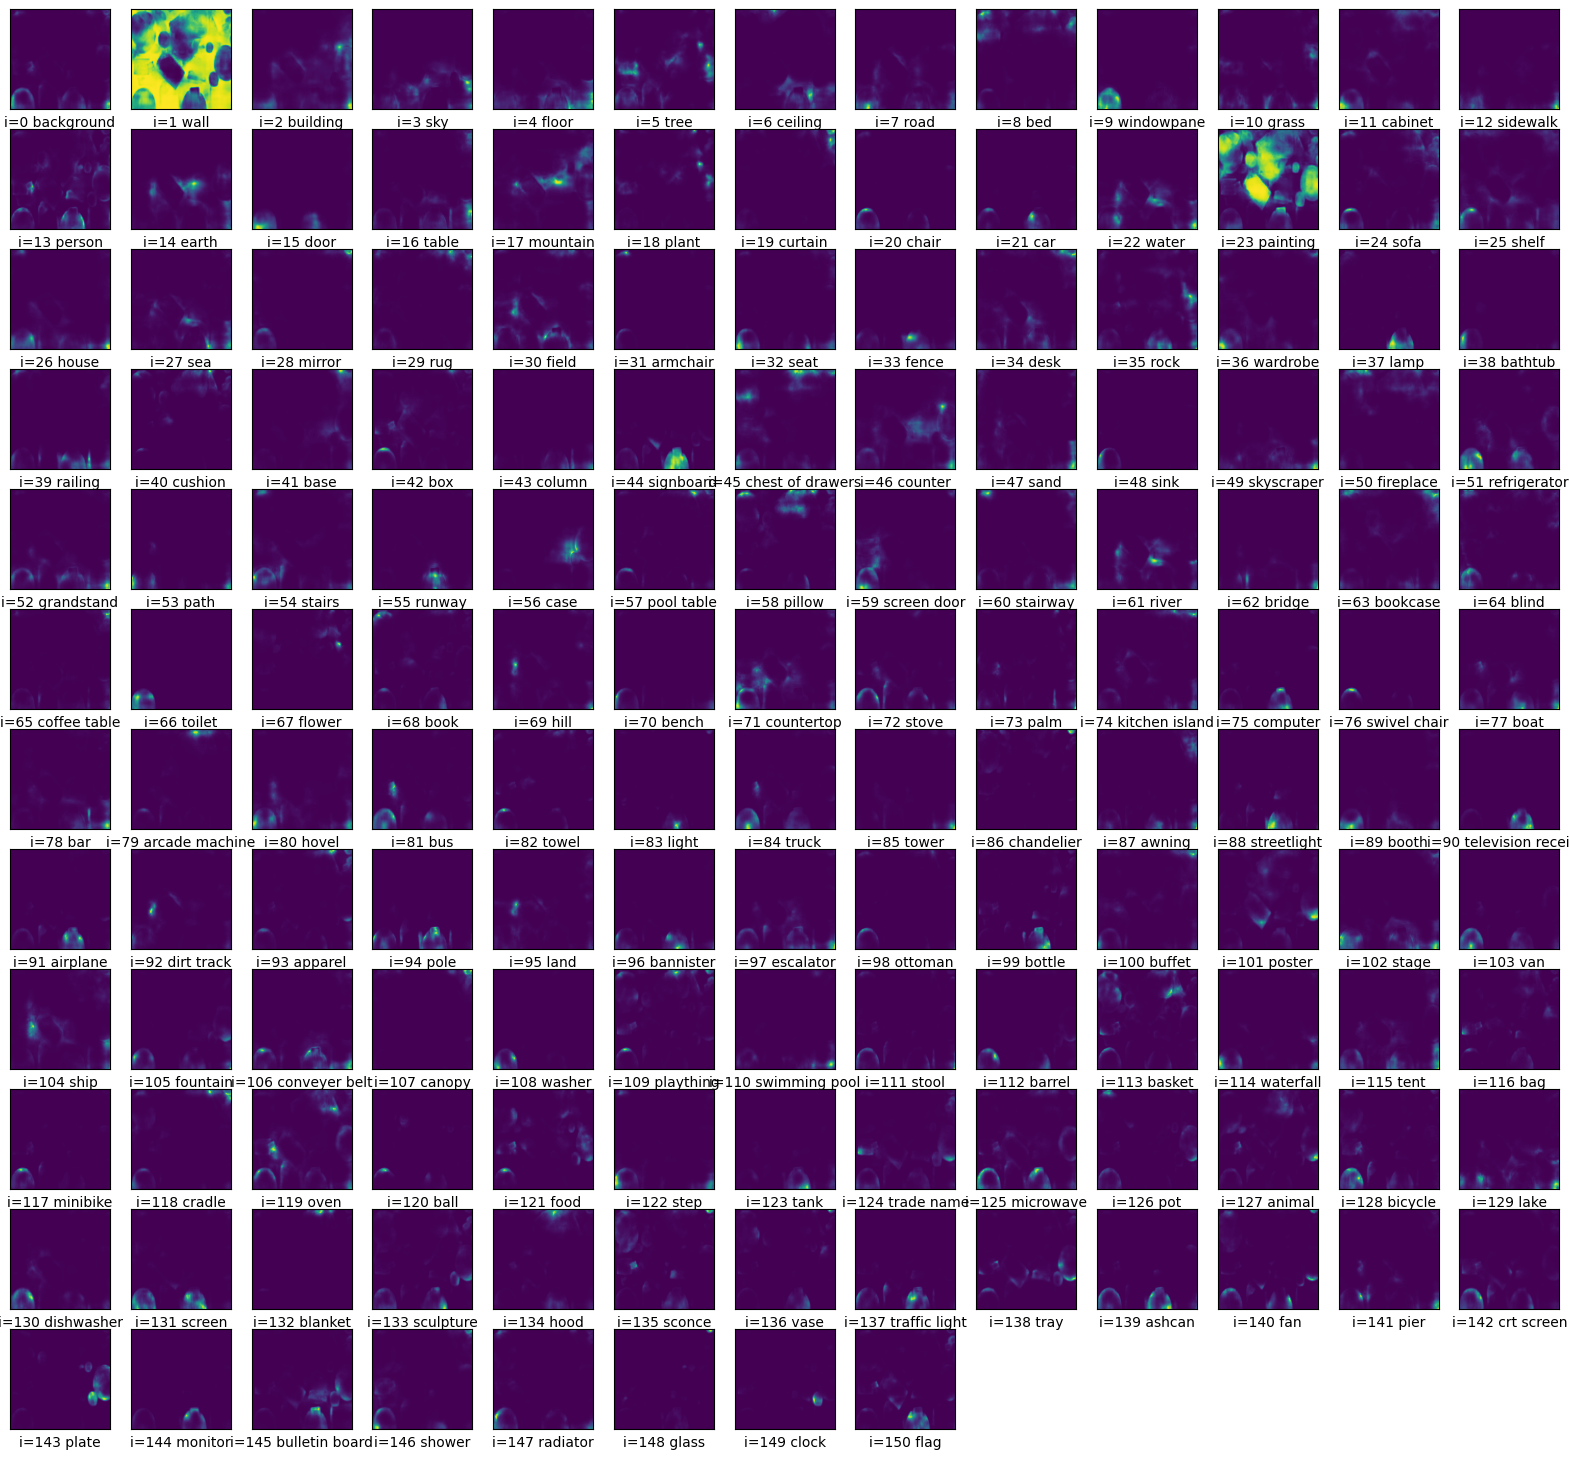

In [12]:
import math

predictions = segmentation_ade20k_model.predict(image) # Predictions will have shape (batch_size, h, w, output_classes=202)
predictions=predictions[0]

number_of_masks = predictions.shape[2]
plot_dim = math.ceil(math.sqrt(number_of_masks))

plt.figure(figsize=(20,20))
for i in range(plot_dim*plot_dim):
    plt.subplot(plot_dim,plot_dim,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predictions[:,:,i])
    plt.xlabel(f'i={i} {classes_segmentation[i]}')
    if i > number_of_masks-2:
      break
plt.show()


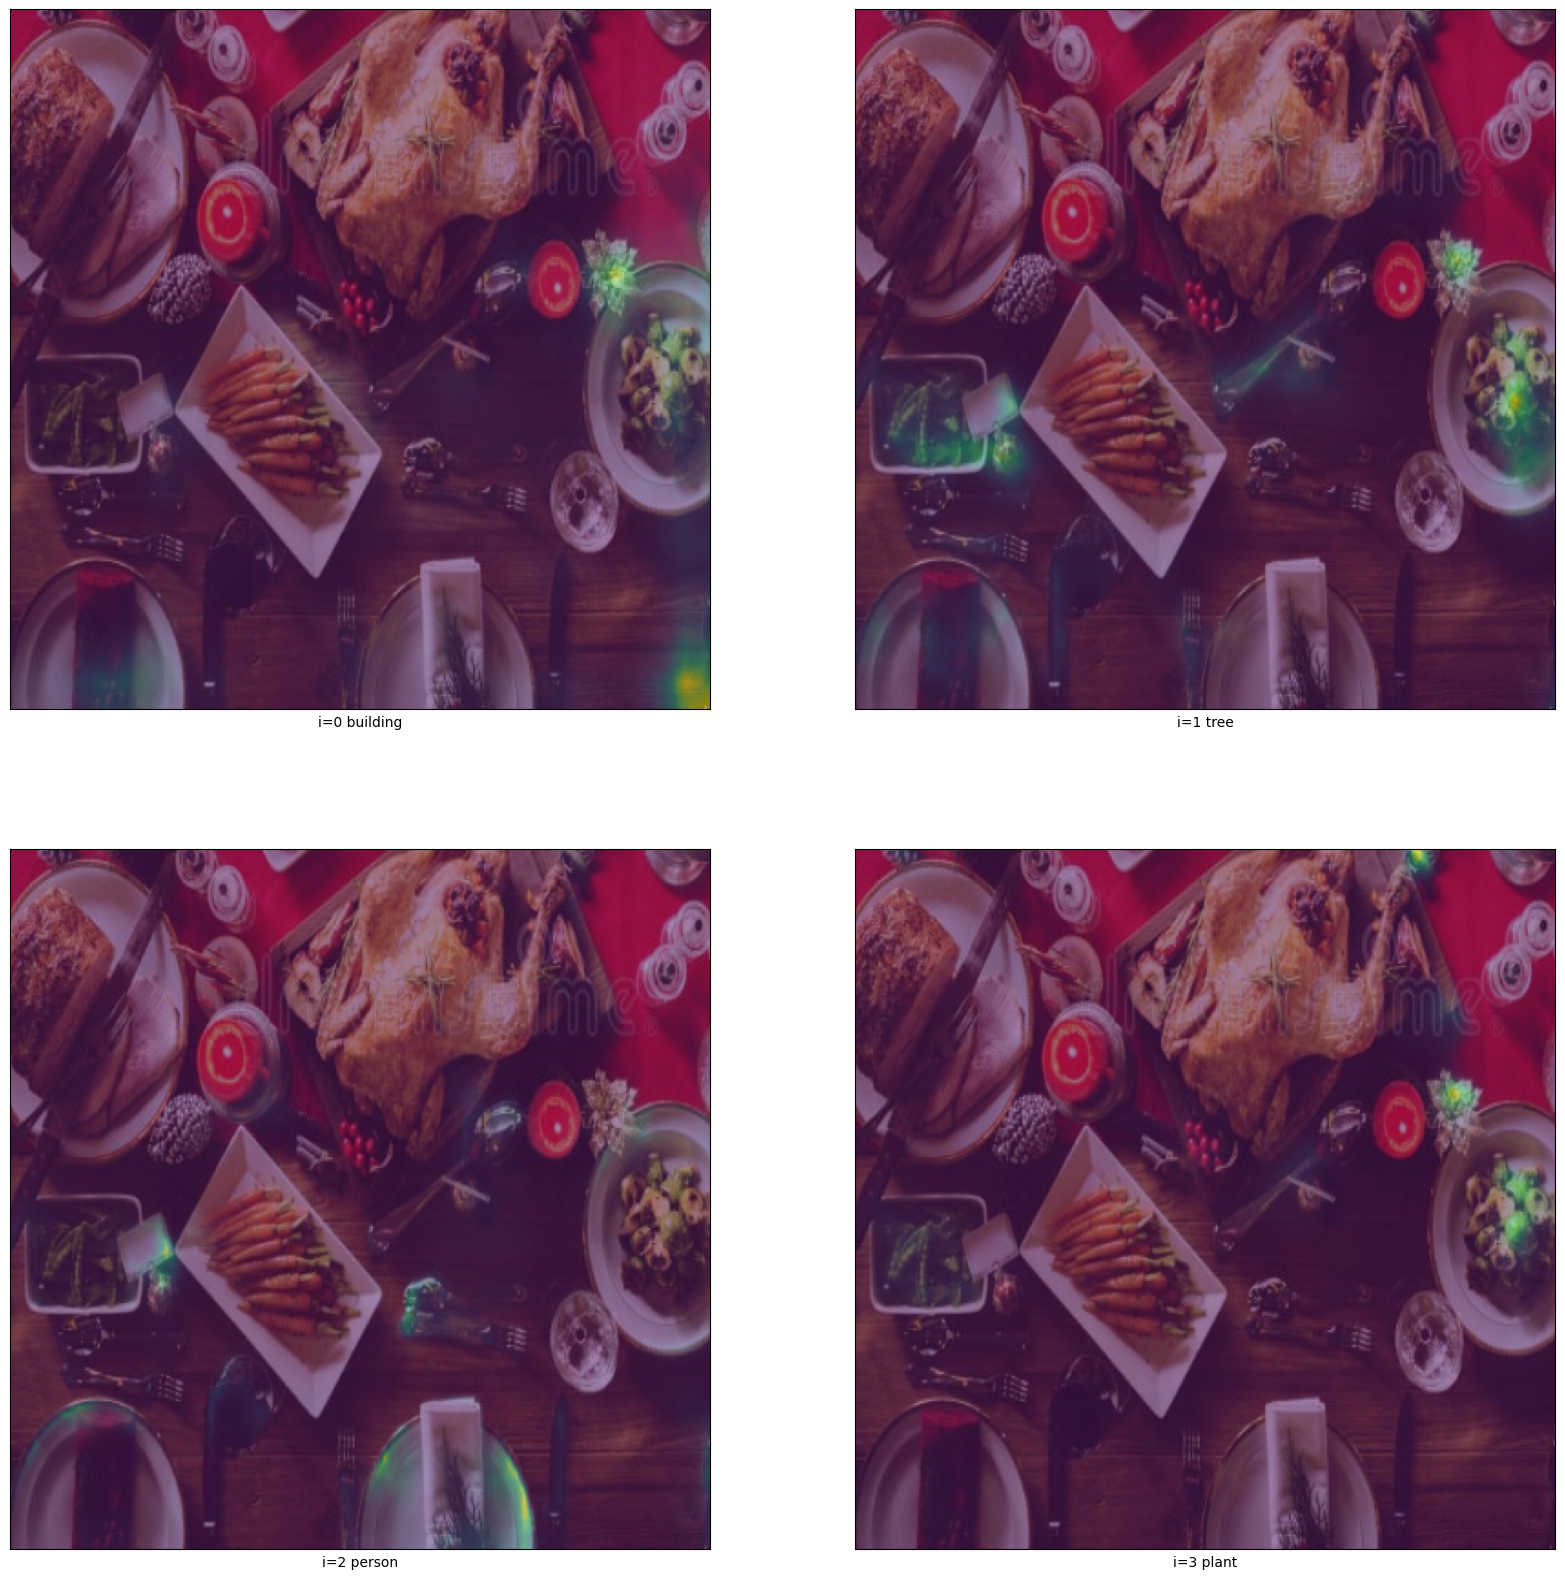

In [13]:
masks = [predictions[:, :, i] for i in [2, 5, 13, 18]]

plt.figure(figsize=(20,20))
for i in range(len(masks)):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[0])
    plt.imshow(masks[i], alpha=0.5)
    plt.xlabel(f'i={i} {classes_segmentation[[2, 5, 13, 18][i]]}')
plt.show()